In [1]:
from pathlib import Path
import urllib, tarfile, os, zipfile, shutil
import pandas as pd
from fastai.vision import *
from fastai.widgets import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    tf = tarfile.open(fn)
    print('extracting', fn, '...')
    tf.extractall()

In [2]:
path = Path('images/')
path.ls()

[PosixPath('images/train'),
 PosixPath('images/test'),
 PosixPath('images/models')]

In [13]:
path_train = path/'train'

['00017903_006.png',
 '00010308_005.png',
 '00028864_004.png',
 '00026747_001.png',
 '00027320_012.png']

In [ ]:
path_train.mkdir()

In [33]:
train_val_txt = open('train_val_list.txt', 'r')
train_txt_split = train_val_txt.read().splitlines()
for fname in train_txt_split:
    shutil.move(path/fname, path_train/fname)

In [15]:
path_test = path/'test'

In [ ]:
path_test.mkdir()

In [29]:
test_txt = open('test_list.txt', 'r')
test_txt_split = test_txt.read().splitlines()
for fname in test_txt_split:
    shutil.move(path/fname, path_test/fname)

In [21]:
df = pd.read_csv('Data_Entry_2017.csv')
df = df[['Image Index','Finding Labels']]

In [22]:
df.tail()

,Image Index,Finding Labels
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding
112119,00030805_000.png,No Finding


In [16]:
fnames_train = get_image_files(path_train)
fnames_train_str = [str(fname)[13:] for fname in fnames_train]; fnames_train_str[:5]

['00028246_000.png',
 '00015058_021.png',
 '00020213_014.png',
 '00007018_054.png',
 '00020429_028.png']

In [19]:
fnames_test = get_image_files(path_test)
fnames_test_str = [str(fname)[12:] for fname in fnames_test]; fnames_test_str[:5]

['00028246_000.png',
 '00015058_021.png',
 '00020213_014.png',
 '00007018_054.png',
 '00020429_028.png']

In [23]:
# todo: optimise bellow line since now it takes a few minutes
df_modified = df.replace(fnames_train_str, ['train/'+fname for fname in fnames_train_str])
df_modified.head()

,Image Index,Finding Labels
0,train/00000001_000.png,Cardiomegaly
1,train/00000001_001.png,Cardiomegaly|Emphysema
2,train/00000001_002.png,Cardiomegaly|Effusion
3,train/00000002_000.png,No Finding
4,00000003_000.png,Hernia


In [24]:
df_modified.replace(fnames_test_str, ['test/'+fname for fname in fnames_test_str], inplace=True)
df_modified.head()

,Image Index,Finding Labels
0,train/00000001_000.png,Cardiomegaly
1,train/00000001_001.png,Cardiomegaly|Emphysema
2,train/00000001_002.png,Cardiomegaly|Effusion
3,train/00000002_000.png,No Finding
4,test/00000003_000.png,Hernia


In [11]:
df_modified['is_valid'] = [True if 'test' in x else False for x in df_modified['Image Index']]

In [17]:
df_modified.head()

,Image Index,Finding Labels,is_valid
112115,train/00030801_001.png,Mass|Pneumonia,False
112116,test/00030802_000.png,No Finding,True
112117,test/00030803_000.png,No Finding,True
112118,test/00030804_000.png,No Finding,True
112119,test/00030805_000.png,No Finding,True


In [19]:
df_modified.to_csv('Data_Entry_2017_modified.csv', index=False)

In [3]:
df_modified = pd.read_csv('Data_Entry_2017_modified.csv')
df_modified.head()

,Image Index,Finding Labels,is_valid
0,train/00000001_000.png,Cardiomegaly,False
1,train/00000001_001.png,Cardiomegaly|Emphysema,False
2,train/00000001_002.png,Cardiomegaly|Effusion,False
3,train/00000002_000.png,No Finding,False
4,test/00000003_000.png,Hernia,True


In [4]:
bs=64

In [5]:
np.random.seed(42)
src = (ImageList.from_df(df=df_modified, path=path)
       .split_from_df()
       .label_from_df(label_delim='|'))

In [6]:
tfms = get_transforms(flip_vert=False, max_warp=0.)

In [14]:
data = (src.transform(tfms, size=224)
        .databunch(bs=bs).normalize(imagenet_stats))

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

In [ ]:
data.classes

In [21]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
acc_03 = partial(accuracy_thresh, thresh=0.3)
f_score = partial(fbeta, thresh=0.5, beta=1)
# for details on wd, look at lesson 5
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, acc_03, f_score], wd=1e-1).to_fp16()

In [73]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


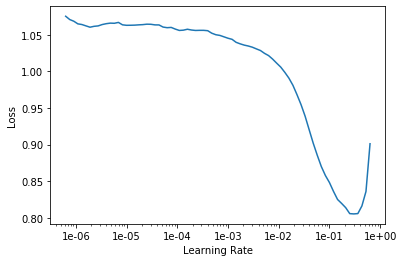

In [74]:
learn.recorder.plot()

In [32]:
lr = 0.03

In [75]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,time
0,0.188682,0.271444,0.836454,0.876420,24:45
1,0.182431,0.294522,0.853034,0.881708,41:00
2,0.173892,0.583354,0.859825,0.893727,38:58
3,0.164289,0.300125,0.864179,0.894291,33:40


In [1]:
learn.save('stage-1-rn50-bs64')

NameError: name 'learn' is not defined

In [27]:
learn.load('stage-1-rn50-bs64')

Learner(data=ImageDataBunch;

Train: LabelList (86524 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
Cardiomegaly,Cardiomegaly;Emphysema,Cardiomegaly;Effusion,No Finding,Mass;Nodule
Path: images;

Valid: LabelList (25596 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
Hernia,Hernia,Hernia,Hernia;Infiltration,Hernia
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNo

In [30]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


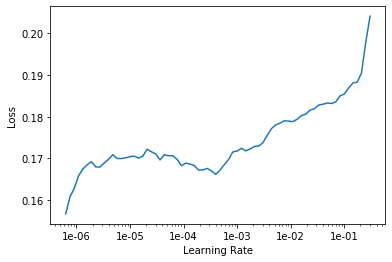

In [31]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(4, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.167143,0.451201,0.854065,0.889885,0.246213,21:43
1,0.164410,0.263567,0.865390,0.896692,0.276881,14:48


In [34]:
learn.save('stage-2-rn50-bs64')

In [ ]:
learn.load('stage-2-rn50-bs64')

In [39]:
learn.fit_one_cycle(1, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.163167,0.238158,0.871928,0.899346,0.273974,15:08


In [40]:
learn.save('stage-3-rn50-bs64')

In [22]:
learn.load('stage-3-rn50-bs64')

Learner(data=ImageDataBunch;

Train: LabelList (86524 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: MultiCategoryList
Cardiomegaly,Cardiomegaly;Emphysema,Cardiomegaly;Effusion,No Finding,Mass;Nodule
Path: images;

Valid: LabelList (25596 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: MultiCategoryList
Hernia,Hernia,Hernia,Hernia;Infiltration,Hernia
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNo

In [17]:
data = (src.transform(tfms, size=448)
        .databunch(bs=bs).normalize(imagenet_stats))

In [23]:
data.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [18]:
learn.data = data

In [31]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


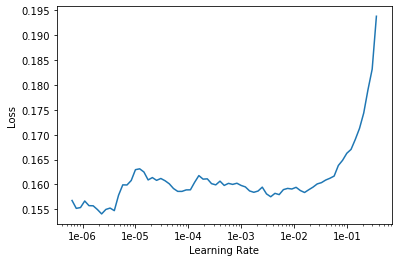

In [32]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr = 1e-2

In [27]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.165447,0.254291,0.875202,0.894481,0.342096,34:49
1,0.166061,0.236470,0.861866,0.895390,0.276755,33:23
2,0.159427,0.229401,0.880150,0.901464,0.268553,33:14
3,0.158698,0.224863,0.869318,0.899349,0.296193,31:22


In [29]:
learn.save('stage-3-448-rn50-bs64-b4-unfreeze')

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


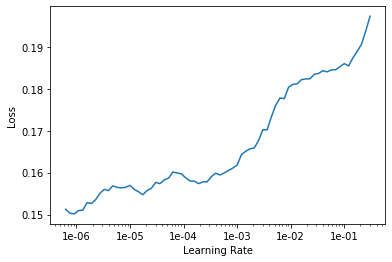

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(2, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.159975,0.227124,0.869808,0.898536,0.299756,34:18
1,0.154347,0.222796,0.867841,0.898851,0.297134,34:26


In [36]:
learn.fit_one_cycle(2, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.156097,0.224525,0.872113,0.898700,0.274944,34:29
1,0.153836,0.221143,0.866739,0.897872,0.301263,35:25


In [37]:
learn.save('stage-3-448-rn50-bs64-after-unfreeze-4es')